# Result Storage

This notebook will show how to store pypesto result objects to be able to load them later on for visualization and further analysis.
This includes sampling, profiling and optimization. Additionally we will show how to use optimization history to look further into an optimization run and how to store the history.

After this notebook you will...
* know how to store and load optimization, profiling and sampling results
* know how to store and load optimization history
* know basic plotting functions for optimization history to inspect optimization convergence

In [1]:
# install if not done yet
# %pip install pypesto --quiet

### Imports

In [2]:
import logging
import random
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from IPython.display import Markdown, display

import pypesto
import pypesto.optimize as optimize
import pypesto.petab
import pypesto.profile as profile
import pypesto.sample as sample
import pypesto.visualize as visualize

mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size'] = 18
# set a random seed to get reproducible results
random.seed(3142)

%matplotlib inline

## 0. Objective function and problem definition

We will use the Boehm model from the [benchmark initiative](https://github.com/Benchmarking-Initiative/Benchmark-Models-PEtab) in this notebook as an example.
We  load the model through [PEtab](https://petab.readthedocs.io/en/latest/), a data format for specifying parameter estimation problems in systems biology.

In [3]:
%%capture
# directory of the PEtab problem
petab_yaml = './boehm_JProteomeRes2014/boehm_JProteomeRes2014.yaml'

importer = pypesto.petab.PetabImporter.from_yaml(petab_yaml)
problem = importer.create_problem(verbose=False)

## 1. Filling in the result file

We will now run a standard parameter estimation pipeline with this model. Aside from the part on the history, we shall not go into detail here,
as this is covered in other tutorials such as [Getting Started](getting_started.ipynb) and [AMICI in pyPESTO](amici.ipynb).

### Optimization

In [4]:
%%time

# create optimizers
optimizer = optimize.FidesOptimizer(
    verbose=logging.ERROR, options={"maxiter": 200}
)

# set number of starts
n_starts = 15  # usually a larger number >=100 is used

# Optimization
result = pypesto.optimize.minimize(
    problem=problem, optimizer=optimizer, n_starts=n_starts
)

  0%|          | 0/15 [00:00<?, ?it/s]

2024-01-03 14:37:53.020 - amici.swig_wrappers - DEBUG - [model1_data1][CVODES:CVode:ERR_FAILURE] AMICI ERROR: in module CVODES in function CVode : At t = 88.7045 and h = 2.40253e-05, the error test failed repeatedly or with |h| = hmin. 
2024-01-03 14:37:53.021 - amici.swig_wrappers - ERROR - [model1_data1][FORWARD_FAILURE] AMICI forward simulation failed at t = 88.7045: AMICI failed to integrate the forward problem
2024-01-03 14:37:53.136 - amici.swig_wrappers - DEBUG - [model1_data1][CVODES:CVode:ERR_FAILURE] AMICI ERROR: in module CVODES in function CVode : At t = 88.4089 and h = 1.02769e-05, the error test failed repeatedly or with |h| = hmin. 
2024-01-03 14:37:53.136 - amici.swig_wrappers - ERROR - [model1_data1][FORWARD_FAILURE] AMICI forward simulation failed at t = 88.4089: AMICI failed to integrate the forward problem
2024-01-03 14:37:53.185 - amici.swig_wrappers - DEBUG - [model1_data1][CVODES:CVode:ERR_FAILURE] AMICI ERROR: in module CVODES in function CVode : At t = 88.5133 

CPU times: user 9.27 s, sys: 519 ms, total: 9.79 s
Wall time: 9.64 s


In [5]:
display(Markdown(result.summary()))

## Optimization Result 

* number of starts: 15 
* best value: 138.2225919756037, id=12
* worst value: 154.16221125364038, id=5
* number of non-finite values: 0

* execution time summary:
	* Mean execution time: 0.641s
	* Maximum execution time: 1.785s,	id=12
	* Minimum execution time: 0.384s,	id=11
* summary of optimizer messages:

  |   Count | Message                                  |
  |--------:|:-----------------------------------------|
  |      11 | Converged according to fval difference   |
  |       4 | Trust Region Radius too small to proceed |

* best value found (approximately) 1 time(s)
* number of plateaus found: 1

A summary of the best run:

### Optimizer Result

* optimizer used: <FidesOptimizer  hessian_update=default verbose=40 options={'maxiter': 200}>
* message: Converged according to fval difference 
* number of evaluations: 178
* time taken to optimize: 1.785s
* startpoint: [-3.82648946  4.99153731 -2.17952968 -1.39145733 -0.5747054   4.45740142
  2.35956422  0.77882698 -2.71223689]
* endpoint: [-1.56909619 -4.98901477 -2.20972883 -1.78588445  4.99964502  4.19771653
  0.58570452  0.81883751  0.49857757]
* final objective value: 138.2225919756037
* final gradient value: [ 6.99548540e-03  5.67684178e-02  4.15813519e-03  1.94420735e-02
 -4.41997844e-05 -7.10489673e-03  9.89156691e-04 -6.98367891e-04
 -4.07797538e-04]
* final hessian value: [[ 2.11240897e+03  6.03813646e-01  1.06890240e+02  2.81533877e+03
   8.82178847e-06 -7.86516037e+02  1.02527778e+02 -8.02295866e+01
  -2.23142988e+01]
 [ 6.03813646e-01  2.01317170e-03 -1.77299630e-01  7.30061900e-01
  -3.70852695e-08 -3.28593144e-01 -1.52623294e-02 -5.82723434e-02
  -5.71794398e-02]
 [ 1.06890240e+02 -1.77299630e-01  6.99968515e+01  1.61225414e+02
   7.01455291e-06 -8.83050425e+01 -3.51659254e+00 -3.02430751e+00
   6.53132559e+00]
 [ 2.81533877e+03  7.30061900e-01  1.61225414e+02  3.76198620e+03
   8.31596889e-06 -1.04206720e+03  1.32794432e+02 -1.05781631e+02
  -2.70575675e+01]
 [ 8.82178847e-06 -3.70852695e-08  7.01455291e-06  8.31596889e-06
   2.74313621e-10 -2.20192310e-04  4.21842641e-05  5.32054764e-05
   6.38402412e-06]
 [-7.86516037e+02 -3.28593144e-01 -8.83050425e+01 -1.04206720e+03
  -2.20192310e-04  9.30413190e+02 -8.20645071e+01  4.93179742e+01
   3.27628925e+01]
 [ 1.02527778e+02 -1.52623294e-02 -3.51659254e+00  1.32794432e+02
   4.21842641e-05 -8.20645071e+01  8.48280922e+01  0.00000000e+00
   0.00000000e+00]
 [-8.02295866e+01 -5.82723434e-02 -3.02430751e+00 -1.05781631e+02
   5.32054764e-05  4.93179742e+01  0.00000000e+00  8.48319778e+01
   0.00000000e+00]
 [-2.23142988e+01 -5.71794398e-02  6.53132559e+00 -2.70575675e+01
   6.38402412e-06  3.27628925e+01  0.00000000e+00  0.00000000e+00
   8.48313088e+01]]


### Profiling

In [6]:
%%time

# Profiling
result = profile.parameter_profile(
    problem=problem,
    result=result,
    optimizer=optimizer,
    profile_index=np.array([1, 1, 1, 0, 0, 0, 0, 0, 1]),
)

100%|██████████| 9/9 [00:05<00:00,  1.53it/s]

CPU times: user 5.66 s, sys: 325 ms, total: 5.98 s
Wall time: 5.88 s


### Sampling

In [7]:
%%time

# Sampling
sampler = sample.AdaptiveMetropolisSampler()
result = sample.sample(
    problem=problem,
    sampler=sampler,
    n_samples=5000,  # rather low
    result=result,
    filename=None,
)

100%|██████████| 5000/5000 [00:05<00:00, 853.90it/s]
Elapsed time: 6.2119409999999995


CPU times: user 5.08 s, sys: 1.14 s, total: 6.22 s
Wall time: 5.86 s


## 2. Storing the result file

We filled all our analyses into one result file. We can now store this result object into HDF5 format to reload this later on.

In [8]:
# create temporary file
fn = tempfile.mktemp(".hdf5")

# write result with write_result function.
# Choose which parts of the result object to save with
# corresponding booleans.
pypesto.store.write_result(
    result=result,
    filename=fn,
    problem=True,
    optimize=True,
    profile=True,
    sample=True,
)

As easy as we can save the result object, we can also load it again:

In [9]:
# load result with read_result function
result_loaded = pypesto.store.read_result(fn)

This problem is not to be used without a separately created objective.


As you can see, when loading the result object, we get a warning regarding the problem. This is the case, as the problem is not fully saved into hdf5, as a big part of the problem is the objective function. Therefore after loading the result object we cannot evaluate the objective function anymore. We can however still use the result object for plotting and further analysis.

The best practice would be to still create the problem through petab and insert it into the result object after loading it.

In [10]:
# dummy call to non-existent objective function would fail
test_parameter = result.optimize_result[0].x[problem.x_free_indices]
# result_loaded.problem.objective(test_parameter)

In [11]:
result_loaded.problem = problem
print(
    f"Objective function call: {result_loaded.problem.objective(test_parameter)}"
)
print(f"Corresponding saved value: {result_loaded.optimize_result[0].fval}")

Objective function call: 138.22259071495967
Corresponding saved value: 138.2225919756037


To show that for visualizations however, the storage and loading of the result object is accurate, we will plot some result visualizations.

## 3. Visualization Comparison

### Optimization

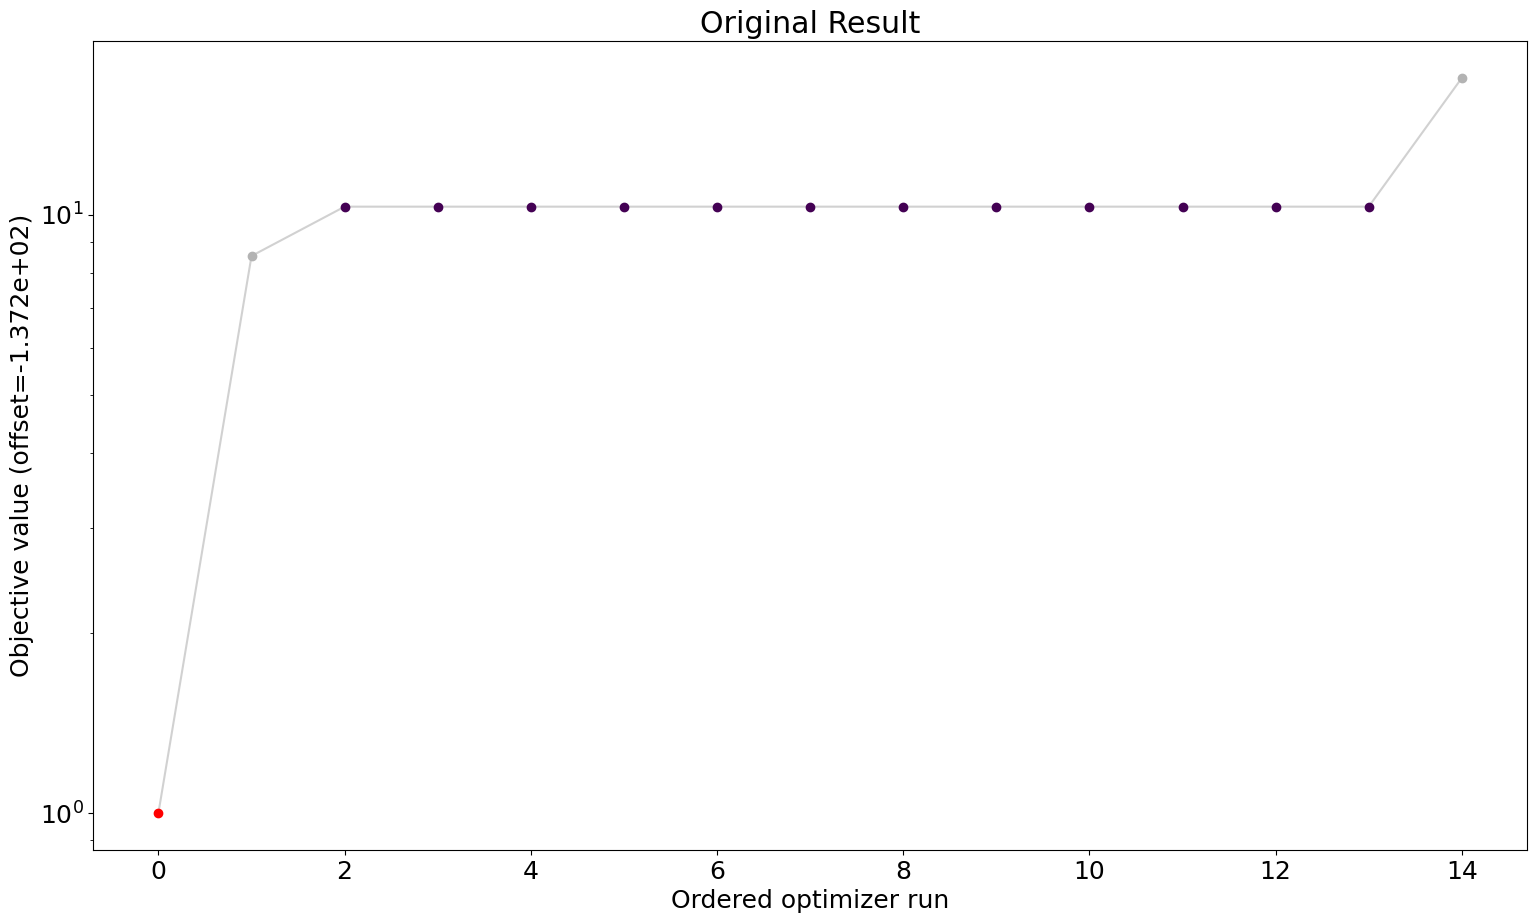

In [12]:
# waterfall plot original
ax = visualize.waterfall(result)
ax.title.set_text("Original Result")

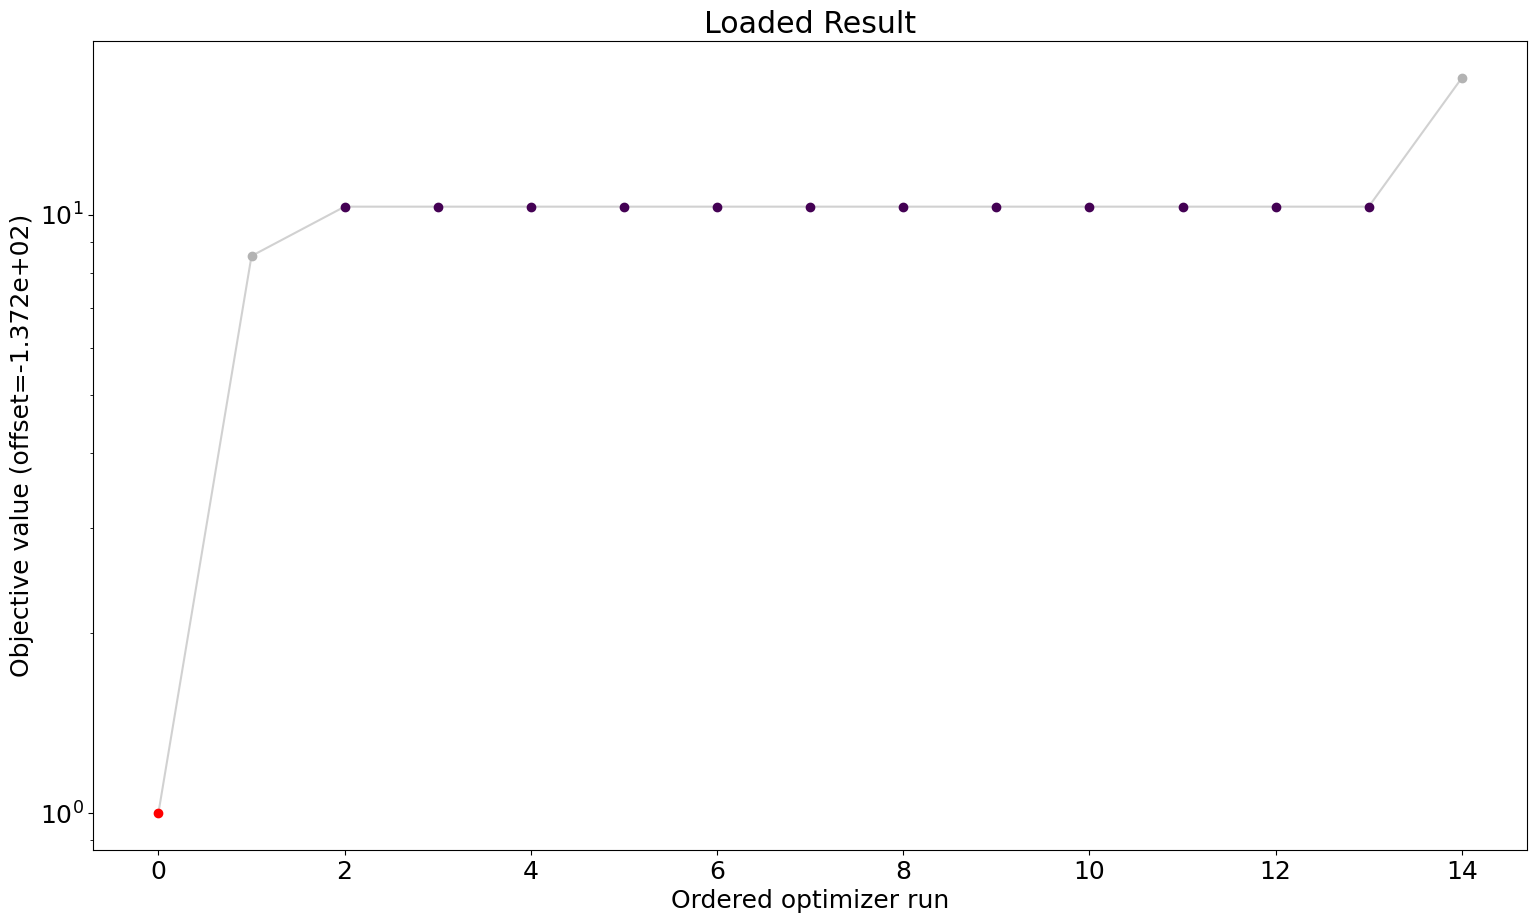

In [13]:
# waterfall plot loaded
ax = visualize.waterfall(result_loaded)
ax.title.set_text("Loaded Result")

### Profiling

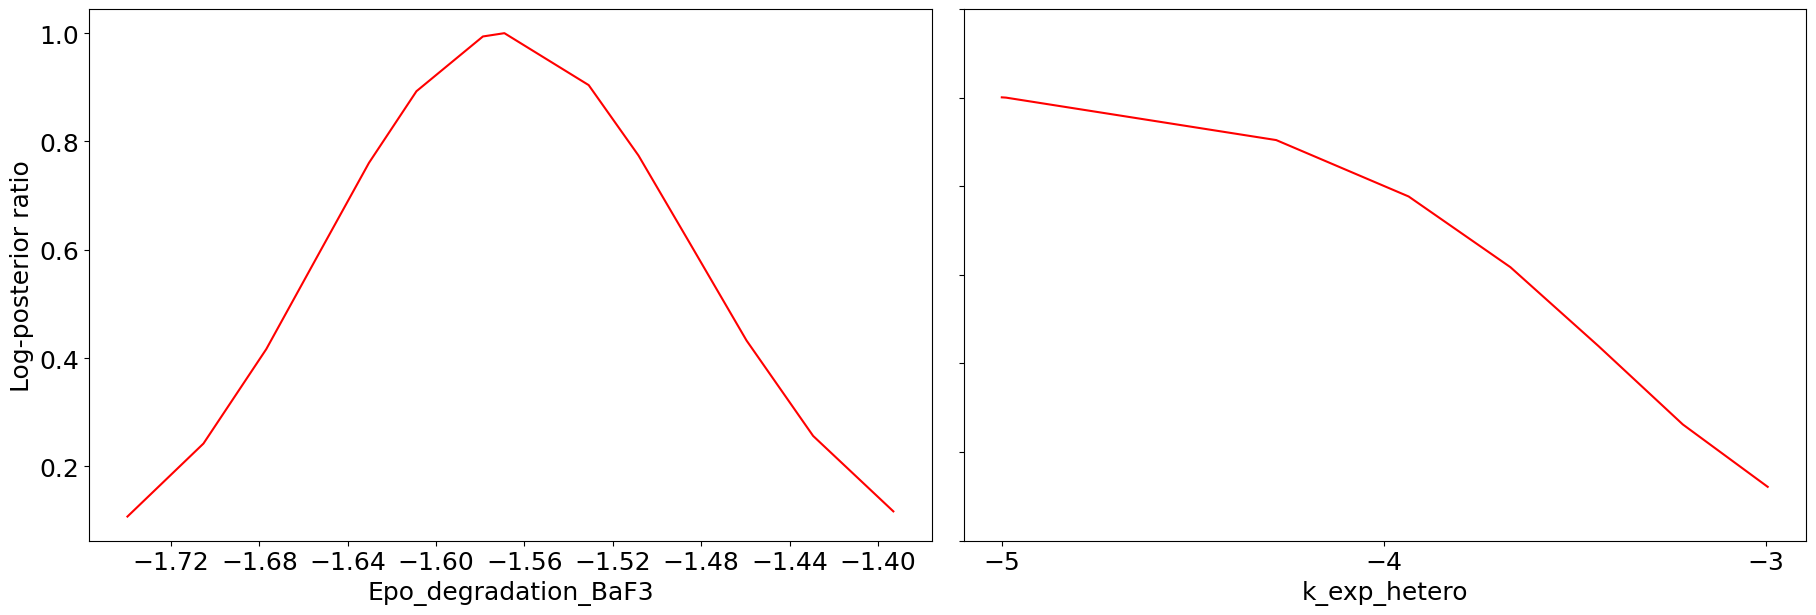

In [14]:
# profile plot original
ax = visualize.profiles(result)

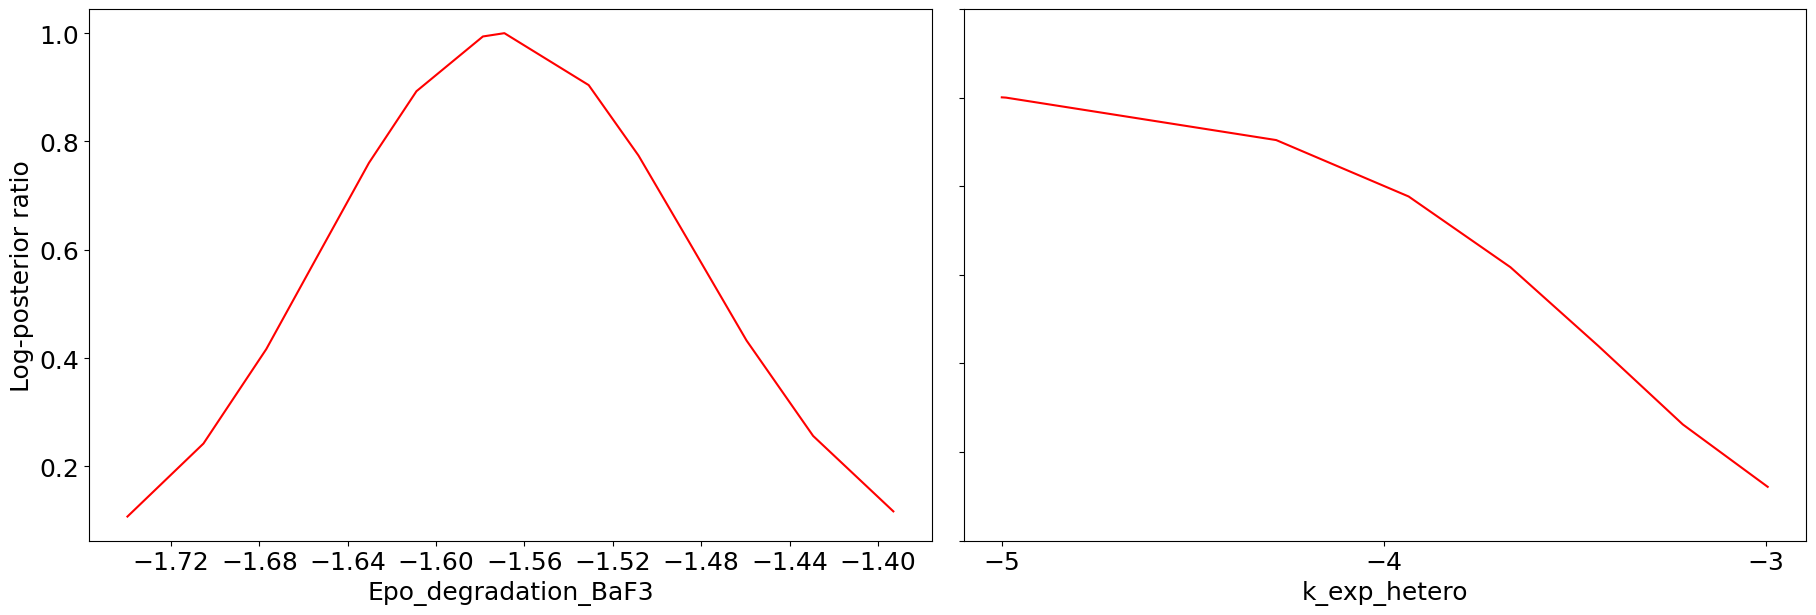

In [15]:
# profile plot loaded
ax = visualize.profiles(result_loaded)

### Sampling

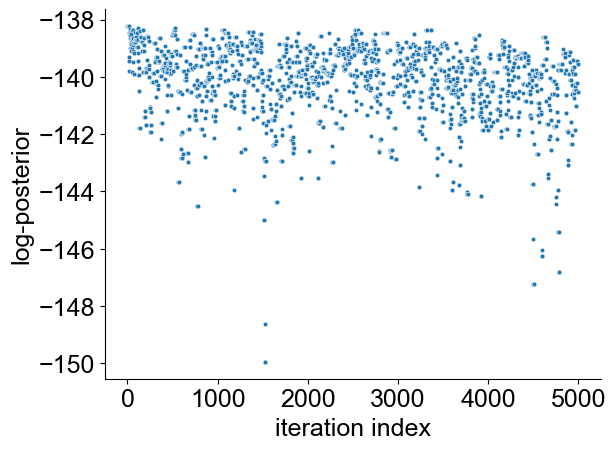

In [16]:
# sampling plot original
ax = visualize.sampling_fval_traces(result)

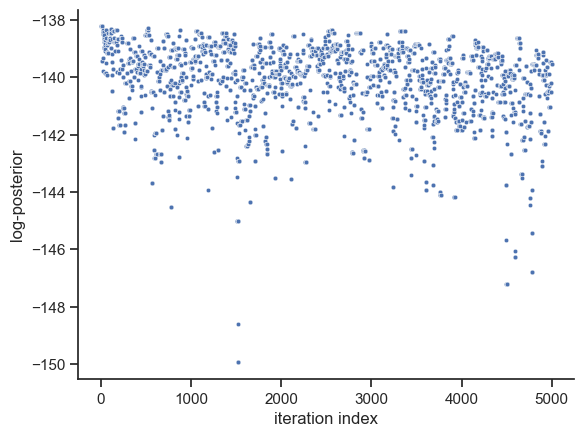

In [17]:
# sampling plot loaded
ax = visualize.sampling_fval_traces(result_loaded)

We can see that we are perfectly able to reproduce the plots from the loaded result object. With this we can reuse the result object for further analysis and visualization again and again without spending time and resources on rerunning the analyses.

## 4. Optimization History

During optimization, it is possible to regularly write the objective function trace to file. This is useful e.g. when runs fail, or for various diagnostics. Currently, pyPESTO can save histories to 3 backends: in-memory, as CSV files, or to HDF5 files.

### Memory History

To record the history in-memory, just set `trace_record=True` in the `pypesto.HistoryOptions`. Then, the optimization result contains those histories:

In [18]:
# record the history
history_options = pypesto.HistoryOptions(trace_record=True)

# Run optimizaitons
result = optimize.minimize(
    problem=problem,
    optimizer=optimizer,
    n_starts=n_starts,
    history_options=history_options,
    filename=None,
)

 27%|██▋       | 4/15 [00:01<00:04,  2.21it/s]2024-01-03 14:38:17.013 - amici.swig_wrappers - DEBUG - [model1_data1][CVODES:CVode:ERR_FAILURE] AMICI ERROR: in module CVODES in function CVode : At t = 91.8632 and h = 2.39949e-05, the error test failed repeatedly or with |h| = hmin. 
2024-01-03 14:38:17.013 - amici.swig_wrappers - ERROR - [model1_data1][FORWARD_FAILURE] AMICI forward simulation failed at t = 91.8632: AMICI failed to integrate the forward problem
 33%|███▎      | 5/15 [00:02<00:05,  1.85it/s]2024-01-03 14:38:18.379 - amici.swig_wrappers - DEBUG - [model1_data1][CVODES:CVode:ERR_FAILURE] AMICI ERROR: in module CVODES in function CVode : At t = 138.953 and h = 4.03132e-05, the error test failed repeatedly or with |h| = hmin. 
2024-01-03 14:38:18.380 - amici.swig_wrappers - ERROR - [model1_data1][FORWARD_FAILURE] AMICI forward simulation failed at t = 138.953: AMICI failed to integrate the forward problem
 47%|████▋     | 7/15 [00:03<00:04,  1.74it/s]2024-01-03 14:38:19.107 

Now, in addition to queries on the result, we can also access the history.

History type:  <class 'pypesto.history.memory.MemoryHistory'>


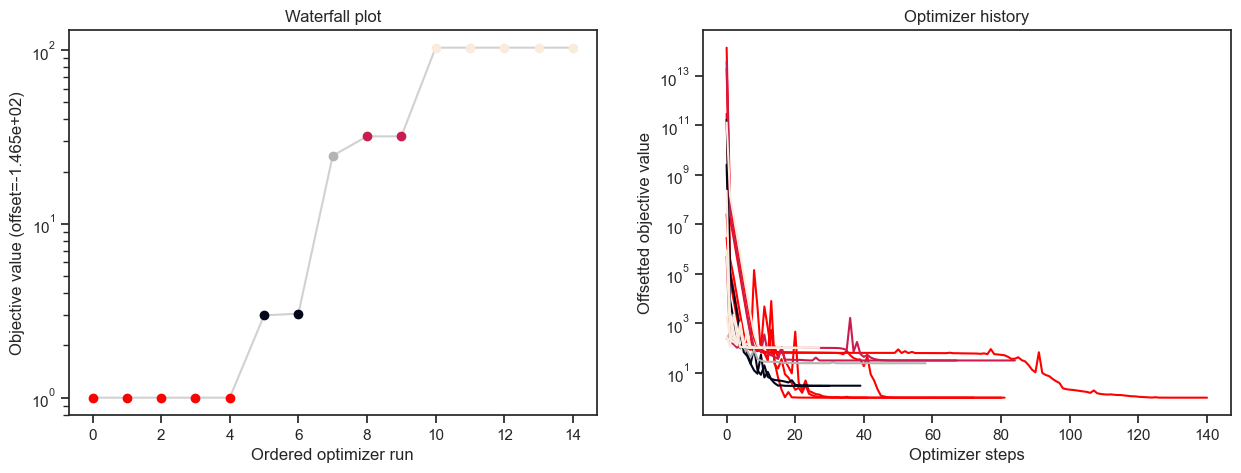

In [19]:
print("History type: ", type(result.optimize_result.list[0].history))
# print("Function value trace of best run: ", result.optimize_result.list[0].history.get_fval_trace())

fig, ax = plt.subplots(1, 2)
visualize.waterfall(result, ax=ax[0])
visualize.optimizer_history(result, ax=ax[1])
fig.set_size_inches((15, 5))

### CSV History

The in-memory storage is however not stored anywhere. To do that, it is possible to store either to CSV or HDF5. This is specified via the `storage_file` option. If it ends in `.csv`, a `pypesto.objective.history.CsvHistory` will be employed; if it ends in `.hdf5` a `pypesto.objective.history.Hdf5History`. Occurrences of the substring `{id}` in the filename are replaced by the multistart id, allowing to maintain a separate file per run (this is necessary for CSV as otherwise runs are overwritten).

In [20]:
# create temporary file
fn_csv = tempfile.mktemp("_{id}.hdf5")
# record the history and store to CSV
history_options = pypesto.HistoryOptions(
    trace_record=True, storage_file=fn_csv
)

# Run optimizaitons
result = optimize.minimize(
    problem=problem,
    optimizer=optimizer,
    n_starts=n_starts,
    history_options=history_options,
    filename=None,
)

  7%|▋         | 1/15 [00:01<00:16,  1.18s/it]2024-01-03 14:38:24.353 - amici.swig_wrappers - DEBUG - [model1_data1][CVODES:CVode:ERR_FAILURE] AMICI ERROR: in module CVODES in function CVode : At t = 97.3155 and h = 1.86559e-05, the error test failed repeatedly or with |h| = hmin. 
2024-01-03 14:38:24.353 - amici.swig_wrappers - ERROR - [model1_data1][FORWARD_FAILURE] AMICI forward simulation failed at t = 97.3155: AMICI failed to integrate the forward problem
2024-01-03 14:38:24.635 - amici.swig_wrappers - DEBUG - [model1_data1][CVODES:CVode:ERR_FAILURE] AMICI ERROR: in module CVODES in function CVode : At t = 143.725 and h = 3.65092e-05, the error test failed repeatedly or with |h| = hmin. 
2024-01-03 14:38:24.635 - amici.swig_wrappers - ERROR - [model1_data1][FORWARD_FAILURE] AMICI forward simulation failed at t = 143.725: AMICI failed to integrate the forward problem
2024-01-03 14:38:24.719 - amici.swig_wrappers - DEBUG - [model1_data1][CVODES:CVode:ERR_FAILURE] AMICI ERROR: in mod

Note that for this simple cost function, saving to CSV takes a considerable amount of time. This overhead decreases for more costly simulators, e.g. using ODE simulations via AMICI.

History type:  <class 'pypesto.history.hdf5.Hdf5History'>


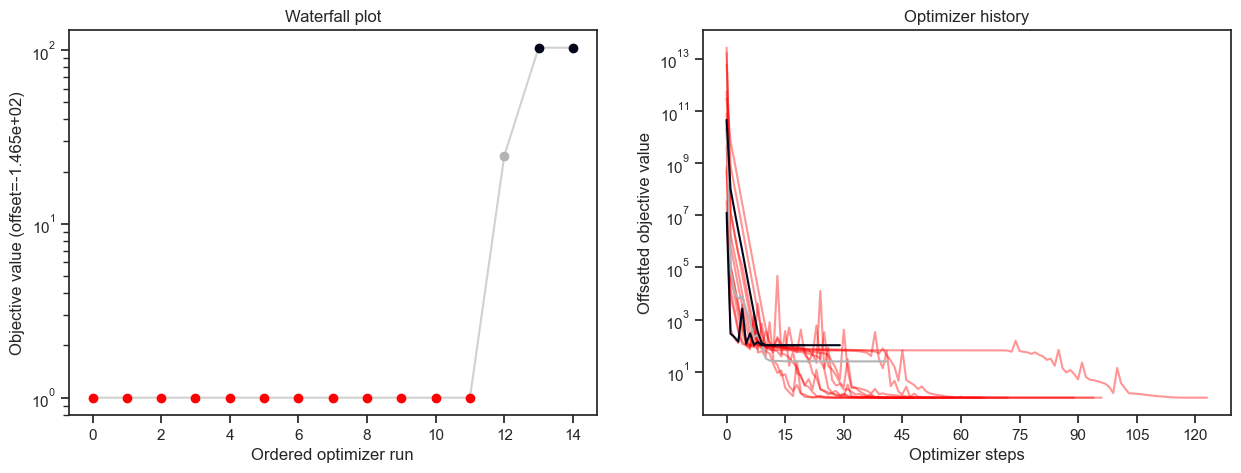

In [21]:
print("History type: ", type(result.optimize_result.list[0].history))
# print("Function value trace of best run: ", result.optimize_result.list[0].history.get_fval_trace())

fig, ax = plt.subplots(1, 2)
visualize.waterfall(result, ax=ax[0])
visualize.optimizer_history(result, ax=ax[1])
fig.set_size_inches((15, 5))

### HDF5 History

Just as in CSV, writing the history to HDF5 takes a considerable amount of time.
If a user specifies a HDF5 output file named `my_results.hdf5` and uses a parallelization engine, then:
* a folder is created to contain partial results, named `my_results/` (the stem of the output filename)
* files are created to store the results of each start, named `my_results/my_results_{START_INDEX}.hdf5`
* a file is created to store the combined result from all starts, named `my_results.hdf5`.
Note that this file depends on the files in the `my_results/` directory, so **cease to function** if
`my_results/` is deleted.

In [22]:
# create temporary file
fn_hdf5 = tempfile.mktemp(".hdf5")
# record the history and store to CSV
history_options = pypesto.HistoryOptions(
    trace_record=True, storage_file=fn_hdf5
)

# Run optimizaitons
result = optimize.minimize(
    problem=problem,
    optimizer=optimizer,
    n_starts=n_starts,
    history_options=history_options,
    filename=fn_hdf5,
)

  0%|          | 0/15 [00:00<?, ?it/s]2024-01-03 14:38:33.692 - amici.swig_wrappers - DEBUG - [model1_data1][CVODES:CVode:ERR_FAILURE] AMICI ERROR: in module CVODES in function CVode : At t = 175.783 and h = 7.70304e-06, the error test failed repeatedly or with |h| = hmin. 
2024-01-03 14:38:33.693 - amici.swig_wrappers - ERROR - [model1_data1][FORWARD_FAILURE] AMICI forward simulation failed at t = 175.783: AMICI failed to integrate the forward problem
2024-01-03 14:38:33.709 - amici.swig_wrappers - DEBUG - [model1_data1][CVODES:CVode:ERR_FAILURE] AMICI ERROR: in module CVODES in function CVode : At t = 229.277 and h = 1.9884e-05, the error test failed repeatedly or with |h| = hmin. 
2024-01-03 14:38:33.709 - amici.swig_wrappers - ERROR - [model1_data1][FORWARD_FAILURE] AMICI forward simulation failed at t = 229.277: AMICI failed to integrate the forward problem
2024-01-03 14:38:33.901 - amici.swig_wrappers - DEBUG - [model1_data1][CVODES:CVode:ERR_FAILURE] AMICI ERROR: in module CVODE

History type:  <class 'pypesto.history.hdf5.Hdf5History'>


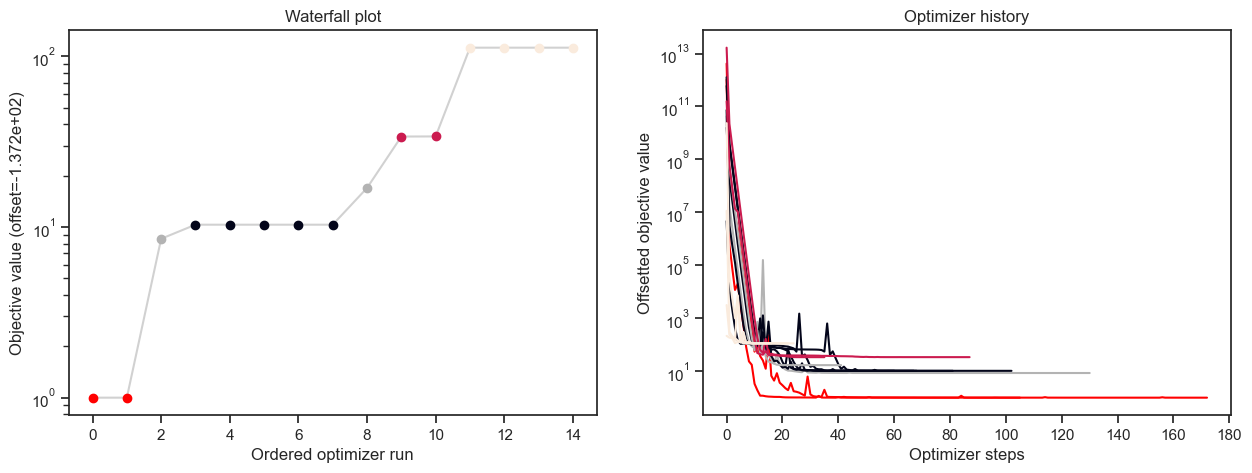

In [23]:
print("History type: ", type(result.optimize_result.list[0].history))
# print("Function value trace of best run: ", result.optimize_result.list[0].history.get_fval_trace())

fig, ax = plt.subplots(1, 2)
visualize.waterfall(result, ax=ax[0])
visualize.optimizer_history(result, ax=ax[1])
fig.set_size_inches((15, 5))

For the HDF5 history, it is possible to load the history from file, and to plot it, together with the optimization result.

This problem is not to be used without a separately created objective.
Loading the profiling result failed. It is highly likely that no profiling result exists within /var/folders/81/7b90kj9j2gz36205mdbf75y40000gn/T/tmpsf5ostbz.hdf5.
Loading the sampling result failed. It is highly likely that no sampling result exists within /var/folders/81/7b90kj9j2gz36205mdbf75y40000gn/T/tmpsf5ostbz.hdf5.


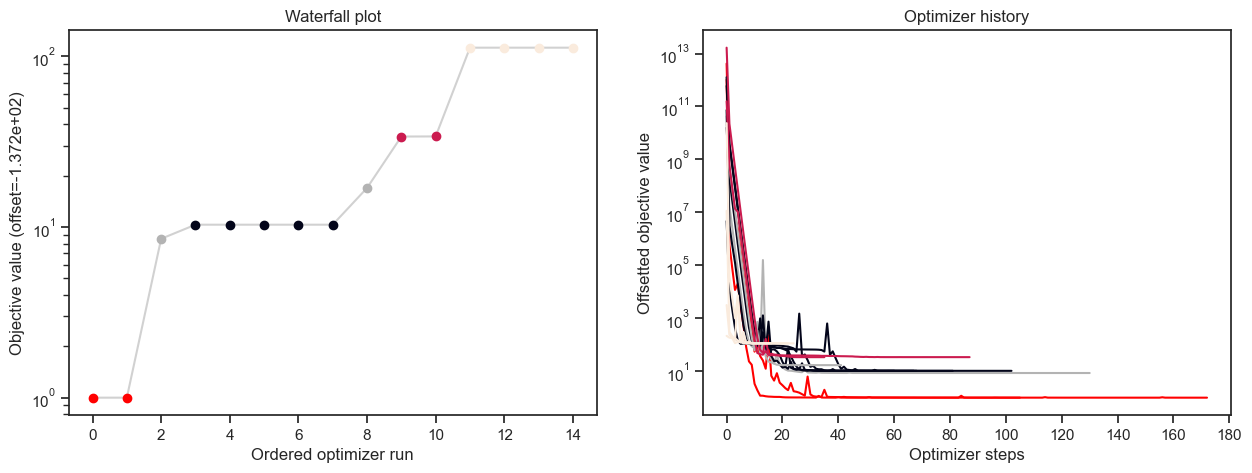

In [24]:
# load the history
result_loaded_w_history = pypesto.store.read_result(fn_hdf5)

fig, ax = plt.subplots(1, 2)
visualize.waterfall(result_loaded_w_history, ax=ax[0])
visualize.optimizer_history(result_loaded_w_history, ax=ax[1])
fig.set_size_inches((15, 5))